In [1]:
from multiClass_unet import multi_unet_model 

from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from data import *

In [2]:
SIZE_X = 256 
SIZE_Y = 256
n_classes=3

In [3]:
#reading mask data from foldres
train_images = []

for directory_path in glob.glob("Animal/images/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        print(img_path)
        img = cv2.imread(img_path, 1)       
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)

Animal/images\img1.jpg
Animal/images\img11.jpg
Animal/images\img12.jpg
Animal/images\img13.jpg
Animal/images\img14.jpg
Animal/images\img15.jpg
Animal/images\img16.jpg
Animal/images\img17.jpg
Animal/images\img2.jpg
Animal/images\img20.jpg
Animal/images\img21.jpg
Animal/images\img23.jpg
Animal/images\img24.jpg
Animal/images\img25.jpg
Animal/images\img26.jpg
Animal/images\img27.jpg
Animal/images\img28.jpg
Animal/images\img29.jpg
Animal/images\img3.jpg
Animal/images\img30.jpg
Animal/images\img4.jpg
Animal/images\img5.jpg
Animal/images\img6.jpg
Animal/images\img7.jpg
Animal/images\img8.jpg
Animal/images\img9.jpg


In [4]:
train_images = np.array(train_images)

In [5]:
print(train_images.shape)

(26, 256, 256, 3)


In [6]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("Animal/masks/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.tiff"))):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)
        
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [7]:
print(train_masks.shape)

(26, 256, 256)


In [9]:

from keras.preprocessing.image import ImageDataGenerator
from skimage import io

# Construct an instance of the ImageDataGenerator class
# Pass the augmentation parameters through the constructor. 

datagen = ImageDataGenerator(
        rotation_range=45,     #Random rotation between 0 and 45
        width_shift_range=0.2,   #% shift
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='constant', cval=125)    #Also try nearest, constant, reflect, wrap


In [26]:
image_generator = datagen.flow_from_directory(
        'Animal',
        classes = ['images'],
        class_mode = None,
        target_size = (256,256),
        batch_size = 16,
        save_to_dir = "AugmaentedAMska",
        save_prefix  = "image",
        seed = 1)

Found 26 images belonging to 1 classes.


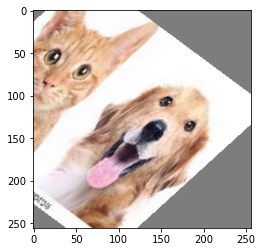

In [27]:
for i in range(4):

  # convert to unsigned integers for plotting
  image = next(image_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  plt.imshow(image)
  

In [30]:
 mask_generator = datagen.flow_from_directory(
        'Animal',
        classes = ['masks'],
        class_mode = None,
        color_mode = 'grayscale',
        target_size = (256,256),
        batch_size = 16,
        save_to_dir = "AugmentedNewFoldr",
        save_prefix  = "image",
        seed = 1)

Found 26 images belonging to 1 classes.


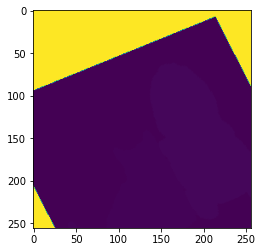

In [31]:
for i in range(10):

  # convert to unsigned integers for plotting
  image = next(mask_generator)[0].astype('uint8')

  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  plt.imshow(image)

In [ ]:
imags=[]
flag=[]
train_generator = zip(image_generator, mask_generator)
for (img,mask) in train_generator:
    img,mask = adjustData(img,mask,False,3)
    #yield (img,mask)
    flag.append(mask)
    imags.append(img)
aug_train_images=np.array(imags)
aug_train_mask=np.array(mask)

In [34]:
i = 0
for batch in datagen.flow(train_images, batch_size=16,  
                          save_to_dir='AugmaentedAMska', 
                          save_prefix='aug', 
                          save_format='tif'):
    i += 1
    if i > 10:
        break 

In [ ]:
print(aug_train_images.shape)
print(aug_train_mask.shape)

In [20]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(3,'Animal','images','masks',data_gen_args,save_to_dir = "AugmentedNewFoldr")


In [12]:
###############################################
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([0, 1, 2], dtype=int64)

In [13]:
print(train_masks.shape)

(26, 128, 128)


(128, 128)


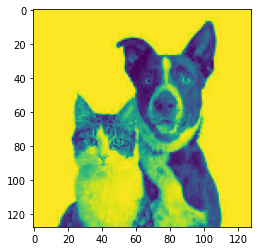

In [14]:
plt.imshow(train_images[5])

print(train_images[0].shape)

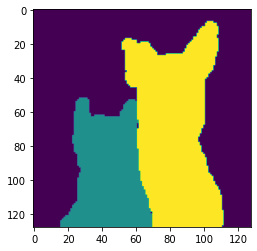

In [15]:
image_x = 5

plt.imshow(train_images[image_x])
plt.imshow(np.squeeze(train_masks[image_x]))


In [16]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#Create a subset of data for quick testing
#Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

#Further split training data t a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)



In [17]:
print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

Class values in the dataset are ...  [0 1 2]


In [18]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))



test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [19]:
print(y_train_cat.shape)

(18, 128, 128, 3)


In [38]:
def unet(pretrained_weights = None,input_size=(256,256,1), n_class=3):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)
    

    up6 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([conv3,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    

    up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv2,up7], axis = 3)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    

    up8 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv1,up8], axis = 3)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv9 = Conv2D(n_class, 1, activation = 'softmax')(conv8)

    model = tf.keras.Model(inputs = inputs, outputs = conv9)

    model.compile(optimizer = Adam(lr = 0.0001), loss = ['binary_crossentropy'], metrics = ['accuracy'])
    #model.compile(optimizer = Adam(lr = 0.0001), loss = [dice_coef_loss], metrics = [dice_coef])
    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [47]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#If starting with pre-trained weights. 
#model.load_weights('???.hdf5')

history = model.fit(X_train, y_train_cat, 
                    batch_size =5 , 
                    verbose=1, 
                    epochs=70, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)
                    


model.save('test.hdf5')


Class weights are...: [0.60167487 1.85424883 1.25208027]
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 128, 128, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 128, 128, 16) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 128, 128, 16) 2320        dropout_18[0][0]                 
___________________________________

4/4 [==============================] - 7s 982ms/step - loss: 1.3296 - accuracy: 0.3774 - val_loss: 1.2413 - val_accuracy: 0.4948
Epoch 2/70
4/4 [==============================] - 4s 933ms/step - loss: 1.2262 - accuracy: 0.4499 - val_loss: 1.1575 - val_accuracy: 0.5189
Epoch 3/70
4/4 [==============================] - 4s 868ms/step - loss: 1.1458 - accuracy: 0.5245 - val_loss: 1.0269 - val_accuracy: 0.6012
Epoch 4/70
4/4 [==============================] - 3s 861ms/step - loss: 1.0620 - accuracy: 0.5434 - val_loss: 1.0713 - val_accuracy: 0.6012
Epoch 5/70
4/4 [==============================] - 4s 916ms/step - loss: 1.0042 - accuracy: 0.5440 - val_loss: 0.9711 - val_accuracy: 0.6012
Epoch 6/70
4/4 [==============================] - 5s 1s/step - loss: 0.9697 - accuracy: 0.5442 - val_loss: 0.9328 - val_accuracy: 0.6012
Epoch 7/70
4/4 [==============================] - 4s 955ms/step - loss: 0.9432 - accuracy: 0.5442 - val_loss: 0.9256 - val_accuracy: 0.6012
Epoch 8/70
4/4 [==================

1/1 [==============================] - 0s 282ms/step - loss: 0.6282 - accuracy: 0.8248
Accuracy is =  82.48087763786316 %


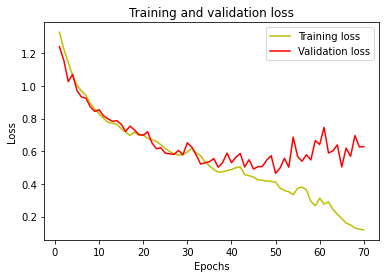

In [48]:
	# evaluate model
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']




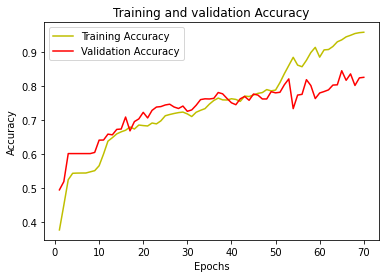

In [49]:
plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




In [50]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


Mean IoU = 0.6179765
[[27912.  1004.   634.     0.]
 [ 1376.  5913.  1376.     0.]
 [ 1242.  2979.  6716.     0.]
 [    0.     0.     0.     0.]]
IoU for class1 is:  0.8676946
IoU for class2 is:  0.46750474
IoU for class3 is:  0.5187302
IoU for class4 is:  nan


<ipython-input-51-284111e597b4>:14: RuntimeWarning: invalid value encountered in float_scalars
  class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])


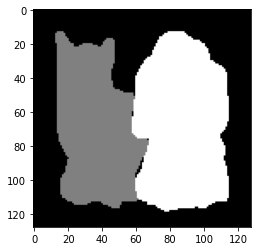

In [51]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[1,0]+ values[2,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')



(128, 128, 1)


TypeError: Invalid shape (128, 128, 1) for image data

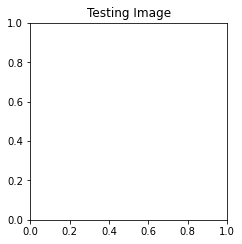

In [59]:
#######################################################################
#Predict on a few images
#model = get_model()
#model.load_weights('???.hdf5')  
import random
test_img_number = 1
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
print(test_img.shape)
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

In [28]:
##loding model
#


import random
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_train, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))

plt.imshow(X_train[ix])



ValueError: in user code:

    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py:414 call
        return self._run_internal_graph(
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\functional.py:550 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\engine\base_layer.py:1037 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\keras\layers\pooling.py:355 call
        outputs = self.pool_function(
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\ops\nn_ops.py:4776 max_pool
        return gen_nn_ops.max_pool(
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py:5340 max_pool
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\func_graph.py:599 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\ops.py:3561 _create_op_internal
        ret = Operation(
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\ops.py:2041 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    c:\users\asad hayyat\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\framework\ops.py:1883 _create_c_op
        raise ValueError(str(e))

    ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node model/max_pooling2d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](model/conv2d_1/Relu)' with input shapes: [32,128,1,16].


(128, 128)


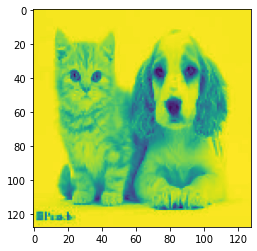

In [100]:
img=train_images[0]/255
print(img.shape)
plt.imshow(img[:,:])